In [ ]:
!pip install pandas scikit-learn matplotlib seaborn nltk

In [ ]:
import pandas as pd
df = pd.read_csv("TestReviews.csv")
df.head()

,review,class
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1


In [ ]:
import pandas as pd

df = pd.read_csv(list(uploaded.keys())[0])


df.columns = df.columns.str.lower().str.strip()

print("Original columns:", df.columns)


for col in df.columns:
    if col in ["review","text","content","review_text","comment"]:
        df = df.rename(columns={col:"review"})

for col in df.columns:
    if col in ["label","class","spam","target","fake"]:
        df = df.rename(columns={col:"label"})

print("Updated columns:", df.columns)

df.head()

Original columns: Index(['review', 'class'], dtype='object')
Updated columns: Index(['review', 'label'], dtype='object')


,review,label
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1


In [ ]:

if df["label"].dtype == "object":
    df["label"] = df["label"].str.lower()
    df["label"] = df["label"].map({
        "fake":1, "spam":1, "deceptive":1,
        "genuine":0, "real":0, "truthful":0
    })

df = df.dropna(subset=["review","label"])
df["label"] = df["label"].astype(int)

In [ ]:
import nltk, re
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z ]',' ', text)
    words = text.split()
    words = [lemm.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean"] = df["review"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic": LogisticRegression(max_iter=2000),
    "NaiveBayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "RandomForest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_vec, y_train)

In [ ]:
from sklearn.metrics import *
import pandas as pd

results = []

for name, model in models.items():
    pred = model.predict(X_test_vec)

    if hasattr(model,"predict_proba"):
        prob = model.predict_proba(X_test_vec)[:,1]
    else:
        prob = pred

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test,pred),
        "Precision": precision_score(y_test,pred),
        "Recall": recall_score(y_test,pred),
        "F1": f1_score(y_test,pred),
        "ROC_AUC": roc_auc_score(y_test,prob),
        "BalancedAcc": balanced_accuracy_score(y_test,pred),
        "MCC": matthews_corrcoef(y_test,pred)
    })

pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC,BalancedAcc,MCC
0,Logistic,0.915607,0.897126,0.991639,0.942017,0.985138,0.868479,0.801923
1,NaiveBayes,0.883237,0.857554,0.996656,0.921887,0.986046,0.812935,0.727567
2,SVM,0.945665,0.945073,0.978261,0.961380,0.925460,0.925460,0.871329
3,RandomForest,0.921387,0.915361,0.976589,0.944984,0.976864,0.887171,0.813047


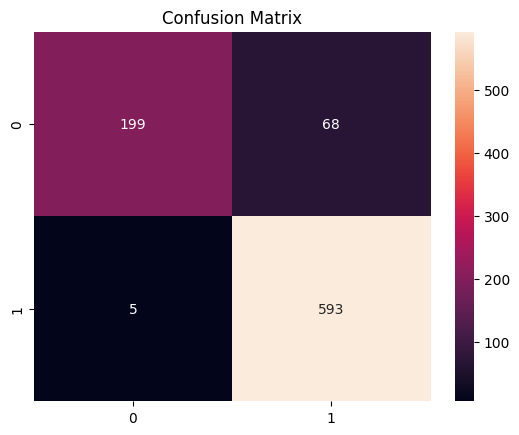

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

best_model = models["Logistic"]
pred = best_model.predict(X_test_vec)

cm = confusion_matrix(y_test,pred)

sns.heatmap(cm,annot=True,fmt="d")
plt.title("Confusion Matrix")
plt.show()

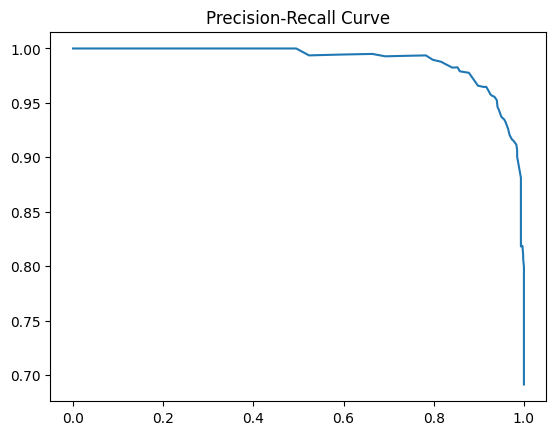

In [ ]:
p,r,_ = precision_recall_curve(y_test,prob)

plt.plot(r,p)
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
import numpy as np

feature_names = tfidf.get_feature_names_out()
coef = best_model.coef_[0]

top_fake = np.argsort(coef)[-15:]
top_real = np.argsort(coef)[:15]

print("Top FAKE words:")
for i in top_fake:
    print(feature_names[i])

print("\nTop GENUINE words:")
for i in top_real:
    print(feature_names[i])

Top FAKE words:
highly
fantastic
nice
perfect
excellent
wonderful
favorite
delicious
friendly
always
awesome
amazing
love
best
great

Top GENUINE words:
worst
rude
money
bad
told
horrible
asked
terrible
would
customer
ordered
said
left
food
awful


In [ ]:
def predict_review(text):
    text = clean_text(text)
    vec = tfidf.transform([text])
    prob = best_model.predict_proba(vec)[0][1]
    label = "Fake" if prob>0.5 else "Genuine"
    return prob, label

predict_review("This product is amazing highly recommended buy now")

(np.float64(0.9606604077236752), 'Fake')